In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.signal import lfilter
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras import backend as K

from ss_perf_utils import *

np.random.seed(2)
torch.manual_seed(2)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def train_numpy(X,y,layer_dims,num_iters,lr,add_del=False):
    sigmoid = lambda z : 1./(1+np.exp(-z))
    
    din,dh,dout = tuple(layer_dims)
    m = X.shape[1]
    delta,prob,epsilon,max_hidden_size,tau = init_add_del()
    losses = []
    num_neurons = []
    
    W1 = np.random.randn(dh,din)
    b1 = np.random.randn(dh,1)
    W2 = np.random.randn(dout,dh)
    b2 = np.random.randn(dout,1)
    
    for t in range(num_iters):
        # Forwardprop
        Z1 = np.dot(W1,X)+b1
        A = Z1.clip(min=0) # relu
        Z2 = np.dot(W2,A)+b2
        yhat = sigmoid(Z2).clip(1e-6,1.-1e-6)
    
        loss = 1./m*(-np.dot(y,np.log(yhat).T)-np.dot(1-y,np.log(1-yhat).T))
        loss = loss.squeeze().item()
        losses.append(loss)
    
        # Backprop
        dyhat = -(np.divide(y,yhat) - np.divide(1-y, 1-yhat))
        dZ2 = dyhat*sigmoid(Z2)*(1-sigmoid(Z2))
        dW2 = 1./m*np.dot(dZ2,A.T)
        db2 = 1./m*np.sum(dZ2,1,keepdims=True)
        dA = np.dot(W2.T,dZ2)
        dZ1 = dA
        dZ1[Z1 < 0] = 0
        dW1 = 1./m*np.dot(dZ1,X.T)
        db1 = 1./m*np.sum(dZ1,1,keepdims=True)
    
        # gradient descent
        W1 -= lr*dW1
        b1 -= lr*db1
        W2 -= lr*dW2
        b2 -= lr*db2

        if add_del and t>tau:
            W1,b1,W2,b2 = delete_neurons_numpy(W1,b1,W2,b2,delta,prob)
            W1,b1,W2,b2 = add_neurons_numpy(W1,b1,W2,b2,losses,epsilon,delta,
                                              max_hidden_size,tau,prob)
        num_neurons.append(b1.shape[0])

        if 0==1:#t % max(1,num_iters // 20) == 0:
            print('loss after iteration %i: %f' % (t, losses[-1]))
            if add_del:
                print('# neurons after iteration %i: %d' % (t, num_neurons[-1]))
    
    return losses,num_neurons

In [4]:
def train_pytorch(X,y,layer_dims,num_iters,lr,device,dtype,add_del=False):
    sigmoid = lambda z : 1./(1+torch.exp(-z))
    
    din,dh,dout = tuple(layer_dims)
    m = X.shape[1]
    delta,prob,epsilon,max_hidden_size,tau = init_add_del()
    losses = []
    num_neurons = []
    
    W1 = torch.randn(dh, din, dtype=dtype, requires_grad=False, device=device)
    b1 = torch.randn(dh, 1, dtype=dtype, requires_grad=False, device=device)
    W2 = torch.randn(dout, dh, dtype=dtype, requires_grad=False, device=device)
    b2 = torch.randn(dout, 1, dtype=dtype, requires_grad=False, device=device)
    
    for t in range(num_iters):
        # Forwardprop
        Z1 = torch.mm(W1,X)+b1
        A = Z1.clamp(min=0) # relu
        Z2 = torch.mm(W2,A)+b2
        yhat = sigmoid(Z2).clamp(1e-6,1.-1e-6)
    
        criterion = nn.BCELoss()
        loss = criterion(yhat,y)
        loss = loss.squeeze_().item()
        losses.append(loss)
    
        # Backprop
        dyhat = -(torch.div(y,yhat) - torch.div(1-y, 1-yhat))
        dZ2 = dyhat*sigmoid(Z2)*(1-sigmoid(Z2))
        dW2 = 1./m*torch.mm(dZ2,A.t())
        db2 = 1./m*torch.sum(dZ2,1,keepdim=True)
        dA = torch.mm(W2.t(),dZ2)
        dZ1 = dA
        dZ1[Z1 < 0] = 0
        dW1 = 1./m*torch.mm(dZ1,X.t())
        db1 = 1./m*torch.sum(dZ1,1,keepdim=True)
    
        # gradient descent
        W1 -= lr*dW1
        b1 -= lr*db1
        W2 -= lr*dW2
        b2 -= lr*db2

        if add_del and t>tau:
            W1,b1,W2,b2 = delete_neurons_pytorch(W1,b1,W2,b2,delta,prob)
            W1,b1,W2,b2 = add_neurons_pytorch(W1,b1,W2,b2,losses,epsilon,delta,max_hidden_size,tau,prob,device)
        num_neurons.append(b1.shape[0])

        if 0==1:#t % max(1,num_iters // 20) == 0:
            print('loss after iteration %i: %f' % (t, losses[-1]))
            if add_del:
                print('# neurons after iteration %i: %d' % (t, num_neurons[-1]))
    
    return losses,num_neurons

In [5]:
def train_tensorflow(X,y,layer_dims,num_iters,lr):
    din,dh,dout = tuple(layer_dims)
    m = X.shape[0]
    delta,prob,epsilon,max_hidden_size,tau = init_add_del()
    losses = []
    num_neurons = []
    
    model = Sequential()
    model.add(Dense(dh, activation='relu', input_dim=din))
    model.add(Dense(dout, activation='sigmoid'))
    sgd = SGD(lr=lr, decay=1., momentum=0., nesterov=False)
    model.compile(loss='binary_crossentropy',optimizer=sgd)
    model.fit(X, y, epochs=num_iters, batch_size=y.shape[0], verbose=0)
    
    return losses,num_neurons

In [6]:
num_runs = 100
num_iters = 1000
num_samples = 10000
num_features = 2
num_hidden = 10
num_classes = 1
lr = 0.1
layer_dims = [num_features,num_hidden,num_classes]

X,y,x1,x2 = gen_data(samples=num_samples,var=0.01)

In [7]:
X_np = X.T
y_np = y.reshape(1,-1)

times_np = []
print('numpy starting')
for run in tqdm(range(num_runs)):
    tin = time.clock()
    losses,num_neurons = train_numpy(X_np,y_np,layer_dims,num_iters,lr,add_del=False)
    tout = time.clock()
    times_np.append(tout-tin)
print('numpy finished')

  0%|          | 0/100 [00:00<?, ?it/s]

numpy starting


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]

numpy finished


In [8]:
device = torch.device('cpu')
dtype = torch.float

X_pt = torch.tensor(X,device=device,dtype=dtype).t()
y_pt = torch.tensor(y,device=device,dtype=dtype).reshape(1,-1)


times_pt_cpu = []
print('pytorch cpu starting')
for run in tqdm(range(num_runs)):
    tin = time.clock()
    losses,num_neurons = train_pytorch(X_pt,y_pt,layer_dims,num_iters,lr,device,dtype,add_del=False)
    tout = time.clock()
    times_pt_cpu.append(tout-tin)
print('pytorch cpu finished')

  0%|          | 0/100 [00:00<?, ?it/s]

pytorch cpu starting


100%|██████████| 100/100 [09:19<00:00,  5.60s/it]

pytorch cpu finished


In [9]:
device = torch.device('cuda:0')
dtype = torch.float

X_pt = torch.tensor(X,device=device,dtype=dtype).t()
y_pt = torch.tensor(y,device=device,dtype=dtype).reshape(1,-1)


times_pt_gpu = []
print('pytorch gpu starting')
for run in tqdm(range(num_runs)):
    tin = time.clock()
    losses,num_neurons = train_pytorch(X_pt,y_pt,layer_dims,num_iters,lr,device,dtype,add_del=False)
    tout = time.clock()
    times_pt_gpu.append(tout-tin)
print('pytorch gpu finished')

  0%|          | 0/100 [00:00<?, ?it/s]

pytorch gpu starting


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

pytorch gpu finished


In [10]:
X_tf = X
y_tf = y

times_tf = []
print('tensorflow starting')
for run in tqdm(range(num_runs)):
    tin = time.clock()
    losses,num_neurons = train_tensorflow(X_tf,y_tf,layer_dims,num_iters,lr)
    tout = time.clock()
    times_tf.append(tout-tin)
print('tensorflow finished')

  0%|          | 0/100 [00:00<?, ?it/s]

tensorflow starting


100%|██████████| 100/100 [12:14<00:00,  7.35s/it]

tensorflow finished


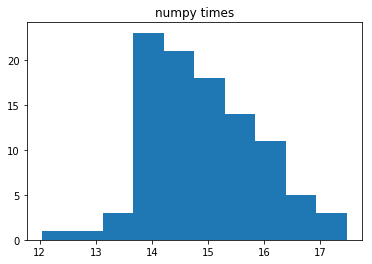

In [11]:
plt.hist(times_np)
plt.title('numpy times')
plt.show()

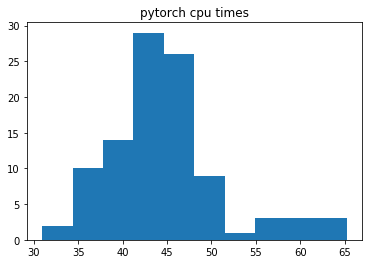

In [12]:
plt.hist(times_pt_cpu)
plt.title('pytorch cpu times')
plt.show()

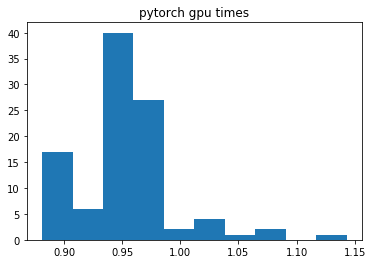

In [13]:
plt.hist(times_pt_gpu)
plt.title('pytorch gpu times')
plt.show()

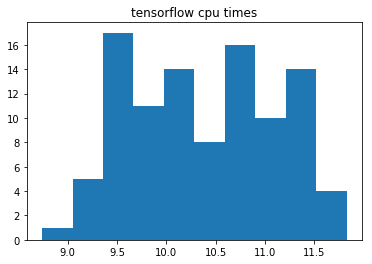

In [14]:
plt.hist(times_tf)
plt.title('tensorflow cpu times')
plt.show()

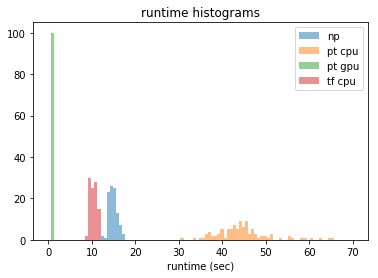

In [18]:
bins = np.linspace(0, 70, 100)

plt.hist(times_np, bins, alpha=0.5, label='np')
plt.hist(times_pt_cpu, bins, alpha=0.5, label='pt cpu')
plt.hist(times_pt_gpu, bins, alpha=0.5, label='pt gpu')
plt.hist(times_tf, bins, alpha=0.5, label='tf cpu')
plt.legend(loc='upper right')
plt.xlabel('runtime (sec)')
plt.title('runtime histograms')
plt.show()

In [20]:
print(np.mean(times_np))
print(np.mean(times_pt_cpu))
print(np.mean(times_pt_gpu))
print(np.mean(times_tf))

14.882525349999995
44.74946808999998
0.9522656399999505
10.37390341999997
